In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
#extract csv from bag files
def data_csv(b):

    csvfiles = []
    for t in b.topics:
        data = b.message_by_topic(t)
        csvfiles.append(data)

    print(csvfiles[0])
    data = pd.read_csv(csvfiles[0])
    return data

In [3]:
b = bagreader("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving.bag")
csv_data = data_csv(b)

[INFO]  Data folder /home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving already exists. Not creating.
/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/gps.csv


In [4]:
df_gps = pd.read_csv("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/gps.csv")

In [5]:
df_imu = pd.read_csv("/home/marley/catkin_ws/src/lab4_driver/bag_files/data_driving/imu.csv")

In [6]:
df_gps

Time  Header.seq  Header.stamp.secs  Header.stamp.nsecs  \
0    1.666914e+09           0              85146                   0   
1    1.666914e+09           0              85147                   0   
2    1.666914e+09           0              85148                   0   
3    1.666914e+09           0              85149                   0   
4    1.666914e+09           0              85151                   0   
..            ...         ...                ...                 ...   
346  1.666915e+09           0              85797                   0   
347  1.666915e+09           0              85798                   0   
348  1.666915e+09           0              85800                   0   
349  1.666915e+09           0              85801                   0   
350  1.666915e+09           0              85802                   0   

    Header.frame_id   Latitude  Longitude  Altitude    UTM_easting  \
0        GPS1_Frame  42.337137 -71.089503       9.7  327865.126969   
1        GPS1_Frame  42.337137 -71.089503       9.5  327865.140245   
2        GPS1_Frame  42.337137 -71.089503       9.3  327865.153975   
3        GPS1_Frame  42.337137 -71.089503       9.2  327865.154430   
4        GPS1_Frame  42.337138 -71.089503       9.1  327865.156249   
..              ...        ...        ...       ...            ...   
346      GPS1_Frame  42.337050 -71.089562      10.0  327860.041275   
347      GPS1_Frame  42.337066 -71.089536      10.1  327862.214558   
348      GPS1_Frame  42.337080 -71.089516      10.3  327863.954003   
349      GPS1_Frame  42.337093 -71.089501      10.9  327865.212872   
350      GPS1_Frame  42.337109 -71.089495      10.8  327865.777842   

     UTM_northing  Zone Letter  
0    4.689324e+06  19.0      T  
1    4.689324e+06  19.0      T  
2    4.689324e+06  19.0      T  
3    4.689324e+06  19.0      T  
4    4.689324e+06  19.0      T  
..            ...   ...    ...  
346  4.689314e+06  19.0      T  
347  4.689316e+06  19.0      T  
348  4.689317e+06  19.0      T  
349  4.689319e+06  19.0      T  
350  4.689321e+06  19.0      T  

[351 rows x 12 columns]

In [7]:
#To transform back matrix - use the calibrated matrix
# matrix = [[ 0.87435829, -0.02553677],
#        [-0.02553677,  0.99480963]]
matrix = [[ 0.8760, -0.0243],
       [-0.0243,  0.9952]]
matrix

[[0.876, -0.0243], [-0.0243, 0.9952]]

In [8]:
offset_x, offset_y = ( -0.1604, -0.011510)

In [9]:
mag_x = df_imu['MagField.magnetic_field.x']
mag_y = df_imu['MagField.magnetic_field.y']

In [10]:
#correct the offset first
corrected_x = mag_x - offset_x
corrected_y = mag_y - offset_y

In [11]:
corrected_coords = []
for i,j in zip(corrected_x, corrected_y):
    corrected_coords.append(matrix * np.matrix([i,j]).transpose())
# corrected_coords

In [12]:
corrected_coords = np.squeeze(np.asarray(corrected_coords))
correct_x = []
correct_y = []
for a in corrected_coords:
    correct_x.append(a[0])
    correct_y.append(a[1])


In [13]:
df_imu['MagField_x'] = correct_x
df_imu['MagField_y'] = correct_y

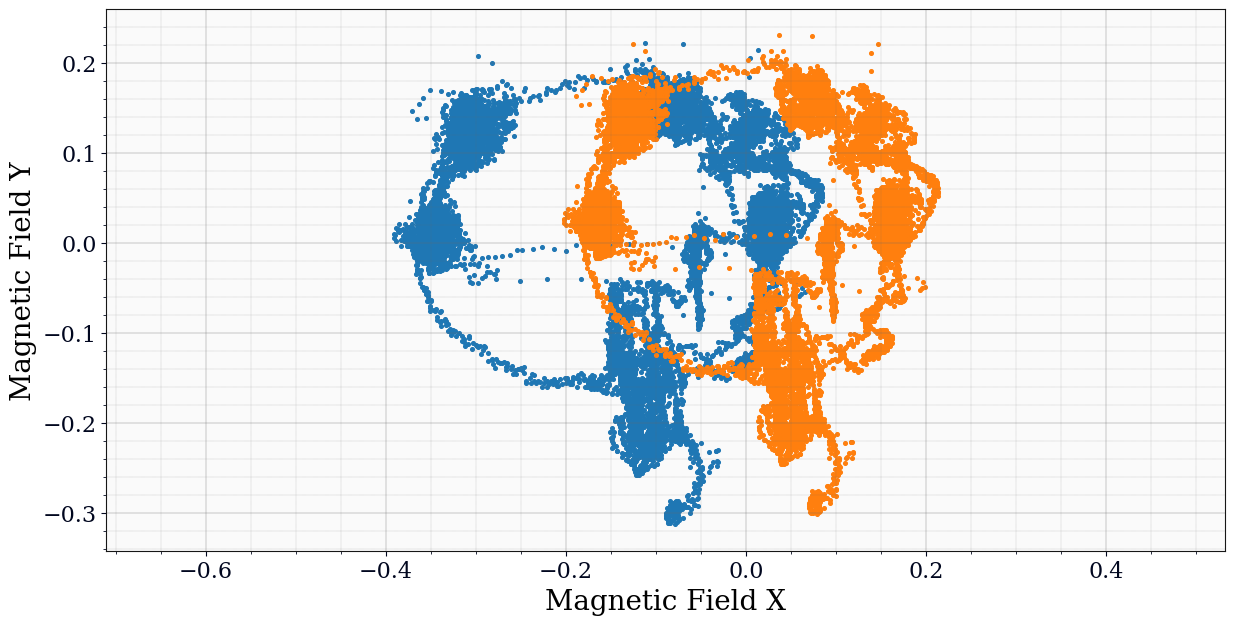

In [14]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].axis('equal')
ax[0].scatter(x='MagField.magnetic_field.x', y='MagField.magnetic_field.y', data=df_imu, s=7)
ax[0].scatter(x='MagField_x', y='MagField_y', data=df_imu, s=7)
plt.xlabel("Magnetic Field X")
plt.ylabel("Magnetic Field Y")
plt.show()


In [15]:
#integrate yaw rate - gyro
accel_x = df_imu['IMU.linear_acceleration.x']

In [16]:
df_imu['time_seconds'] =  df_imu['Header.stamp.secs'] + df_imu['Header.stamp.nsecs']/(10**9)
df_imu['time_seconds_plot'] =  df_imu['time_seconds'] - df_imu['time_seconds'].min(axis=0)
df_imu['time_seconds_plot'] 

0          0.000000
1          0.024930
2          0.049936
3          0.074992
4          0.100404
            ...    
26346    658.650072
26347    658.675356
26348    658.699905
26349    658.724939
26350    658.750218
Name: time_seconds_plot, Length: 26351, dtype: float64

In [17]:
df_gps['time'] = df_gps['Header.stamp.secs'] - df_gps['Header.stamp.secs'].min()
df_gps['time']

0        0
1        1
2        2
3        3
4        5
      ... 
346    651
347    652
348    654
349    655
350    656
Name: time, Length: 351, dtype: int64

In [18]:
from scipy import integrate
y = accel_x
x = df_imu['time_seconds_plot']

vel_x = integrate.cumtrapz( y, x, initial=x[0])
vel_values = []
for v in vel_x:
    vel_values.append(v)
df_imu['linear_vel_x'] = vel_values
df_imu['linear_vel_x']



0          0.000000
1          0.014111
2          0.027839
3          0.041457
4          0.055509
            ...    
26346    481.072472
26347    481.089248
26348    481.105941
26349    481.122827
26350    481.139637
Name: linear_vel_x, Length: 26351, dtype: float64

In [19]:
#standardized data

df_gps['UTM_easting_corrected'] = df_gps['UTM_easting'] - df_gps['UTM_easting'].min()
df_gps['UTM_northing_corrected'] = df_gps['UTM_northing'] - df_gps['UTM_northing'].min()

In [20]:
df_gps['Header.stamp.secs'][1]

85147

In [21]:
#gps velocity
vel_gps = []
# vel_gps.append(gps_vel)
gps_vel_sum = 0
dist_east_zero = df_gps['UTM_easting_corrected'][1] - df_gps['UTM_easting_corrected'][0]
dist_north_zero = df_gps['UTM_northing_corrected'][1] - df_gps['UTM_northing_corrected'][0]
vel_gps_zero  =  np.sqrt(dist_east_zero**2 + dist_north_zero**2)/(df_gps['Header.stamp.secs'][1] -df_gps['Header.stamp.secs'][0])
vel_gps.append(vel_gps_zero)
last = vel_gps_zero
for i in range(1, len(df_gps['UTM_easting_corrected']-1)):
    dist_east = df_gps['UTM_easting_corrected'][i] - df_gps['UTM_easting_corrected'][i-1]
    dist_north = df_gps['UTM_northing_corrected'][i] - df_gps['UTM_northing_corrected'][i-1]
    if(df_gps['Header.stamp.secs'][i] -df_gps['Header.stamp.secs'][i-1] != 0):
        gps_vel = np.sqrt(dist_east**2 + dist_north**2)/np.abs((df_gps['Header.stamp.secs'][i] -df_gps['Header.stamp.secs'][i-1]))
        last = gps_vel
    else:
#         print(vel_gps[i-1])
        gps_vel = 0
    gps_vel_sum = gps_vel_sum + gps_vel
    vel_gps.append(gps_vel)
    

In [22]:
df_gps['vel_gps'] = vel_gps
df_gps['vel_gps_sum'] = gps_vel_sum
df_gps['vel_gps']

0      0.023051
1      0.023051
2      0.013735
3      0.018513
4      0.037025
         ...   
346    0.000000
347    2.809130
348    1.134593
349    1.934642
350    1.834513
Name: vel_gps, Length: 351, dtype: float64

In [23]:
df_gps['vel_gps']
len(df_gps['Header.stamp.secs']), len(df_imu['linear_vel_x'])

(351, 26351)

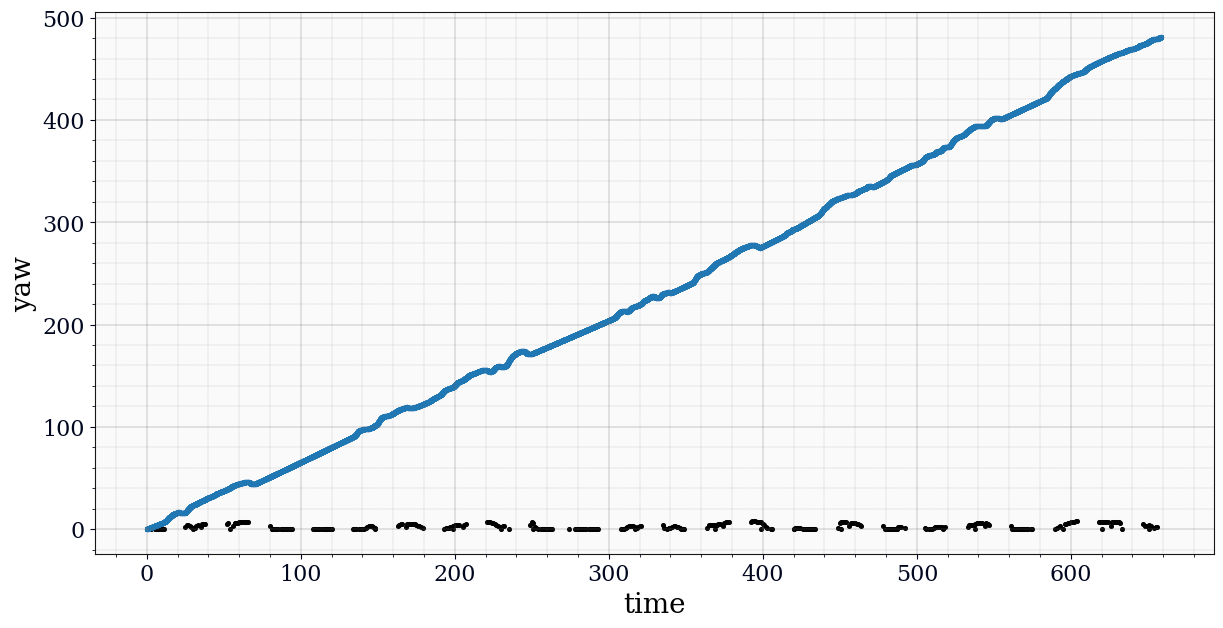

In [24]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_gps['time'], y=df_gps['vel_gps'], c = 'black', s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y= df_imu['linear_vel_x'], s=7)
plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [25]:
df_gps['time'], df_gps['vel_gps']

(0        0
 1        1
 2        2
 3        3
 4        5
       ... 
 346    651
 347    652
 348    654
 349    655
 350    656
 Name: time, Length: 351, dtype: int64,
 0      0.023051
 1      0.023051
 2      0.013735
 3      0.018513
 4      0.037025
          ...   
 346    0.000000
 347    2.809130
 348    1.134593
 349    1.934642
 350    1.834513
 Name: vel_gps, Length: 351, dtype: float64)

In [26]:
df_gps.sort_values('Header.stamp.secs')

Time  Header.seq  Header.stamp.secs  Header.stamp.nsecs  \
0    1.666914e+09           0              85146                   0   
1    1.666914e+09           0              85147                   0   
2    1.666914e+09           0              85148                   0   
3    1.666914e+09           0              85149                   0   
4    1.666914e+09           0              85151                   0   
..            ...         ...                ...                 ...   
346  1.666915e+09           0              85797                   0   
347  1.666915e+09           0              85798                   0   
348  1.666915e+09           0              85800                   0   
349  1.666915e+09           0              85801                   0   
350  1.666915e+09           0              85802                   0   

    Header.frame_id   Latitude  Longitude  Altitude    UTM_easting  \
0        GPS1_Frame  42.337137 -71.089503       9.7  327865.126969   
1        GPS1_Frame  42.337137 -71.089503       9.5  327865.140245   
2        GPS1_Frame  42.337137 -71.089503       9.3  327865.153975   
3        GPS1_Frame  42.337137 -71.089503       9.2  327865.154430   
4        GPS1_Frame  42.337138 -71.089503       9.1  327865.156249   
..              ...        ...        ...       ...            ...   
346      GPS1_Frame  42.337050 -71.089562      10.0  327860.041275   
347      GPS1_Frame  42.337066 -71.089536      10.1  327862.214558   
348      GPS1_Frame  42.337080 -71.089516      10.3  327863.954003   
349      GPS1_Frame  42.337093 -71.089501      10.9  327865.212872   
350      GPS1_Frame  42.337109 -71.089495      10.8  327865.777842   

     UTM_northing  Zone Letter  time  UTM_easting_corrected  \
0    4.689324e+06  19.0      T     0             130.839191   
1    4.689324e+06  19.0      T     1             130.852467   
2    4.689324e+06  19.0      T     2             130.866198   
3    4.689324e+06  19.0      T     3             130.866653   
4    4.689324e+06  19.0      T     5             130.868472   
..            ...   ...    ...   ...                    ...   
346  4.689314e+06  19.0      T   651             125.753497   
347  4.689316e+06  19.0      T   652             127.926781   
348  4.689317e+06  19.0      T   654             129.666226   
349  4.689319e+06  19.0      T   655             130.925095   
350  4.689321e+06  19.0      T   656             131.490064   

     UTM_northing_corrected   vel_gps  vel_gps_sum  
0                 14.409009  0.023051   868.204767  
1                 14.390165  0.023051   868.204767  
2                 14.389827  0.013735   868.204767  
3                 14.408334  0.018513   868.204767  
4                 14.482363  0.037025   868.204767  
..                      ...       ...          ...  
346                4.811903  0.000000   868.204767  
347                6.591805  2.809130   868.204767  
348                8.049040  1.134593   868.204767  
349                9.518083  1.934642   868.204767  
350               11.263433  1.834513   868.204767  

[351 rows x 17 columns]

In [27]:
time = np.linspace(0, 656, num=351)
df_gps['time_Check'] = time

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


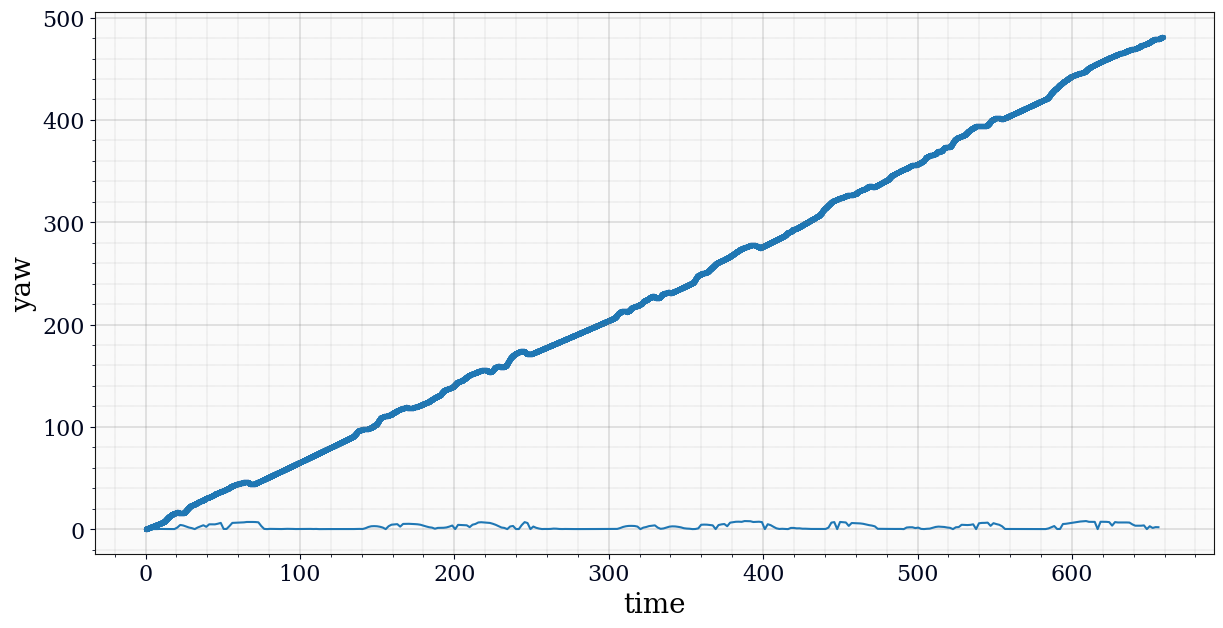

In [28]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
# plt.plot(df_gps['Header.stamp.secs'], df_gps['vel_gps'])
# plt.plot( df_gps['vel_gps'])
ax[0].scatter(x= df_imu['time_seconds_plot'], y= df_imu['linear_vel_x'], s=7)
# ax[0].scatter(x= df_gps['time_Check'] , y=df_gps['vel_gps'], s=7)
plt.plot(df_gps['time_Check'], df_gps['vel_gps'])
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()


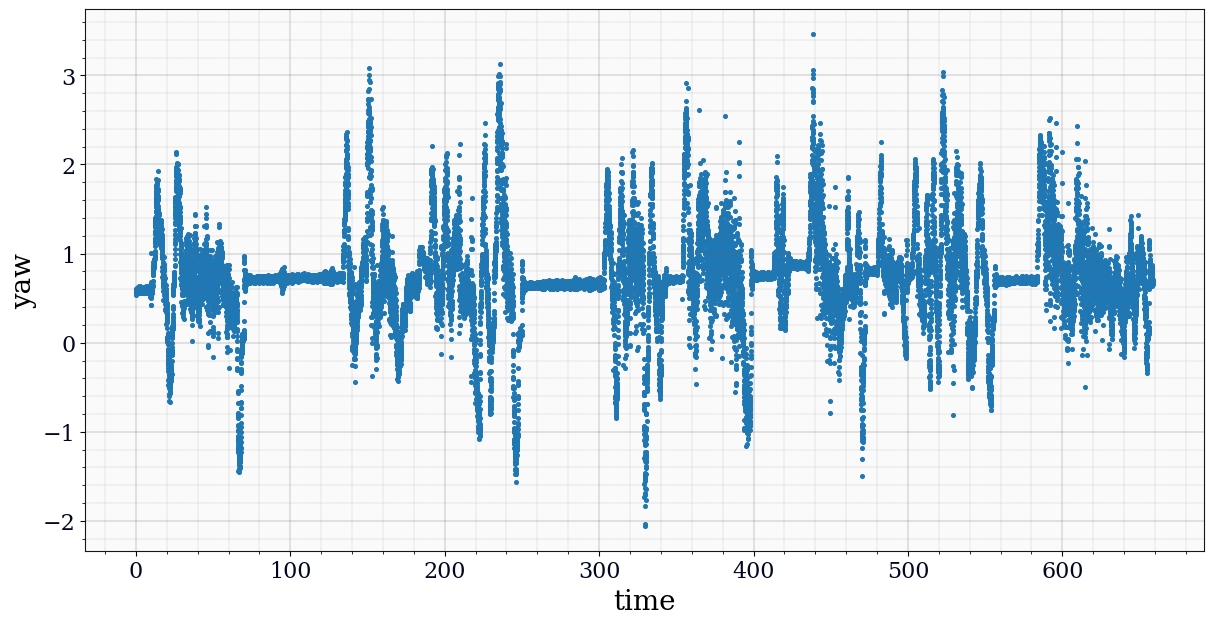

In [29]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=accel_x, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [30]:
alpha = 0.992
accel_values= []
accel_new = accel_x[0]
accel_values.append(accel_new)
for i in range(1, len(accel_x)):
    accel_new  = (1-alpha)*accel_x[i] + (alpha)*accel_values[i-1]
    accel_values.append(accel_new)


In [31]:
df_imu['new_Accel'] = accel_values
df_imu['bias_Accel'] = df_imu['new_Accel']

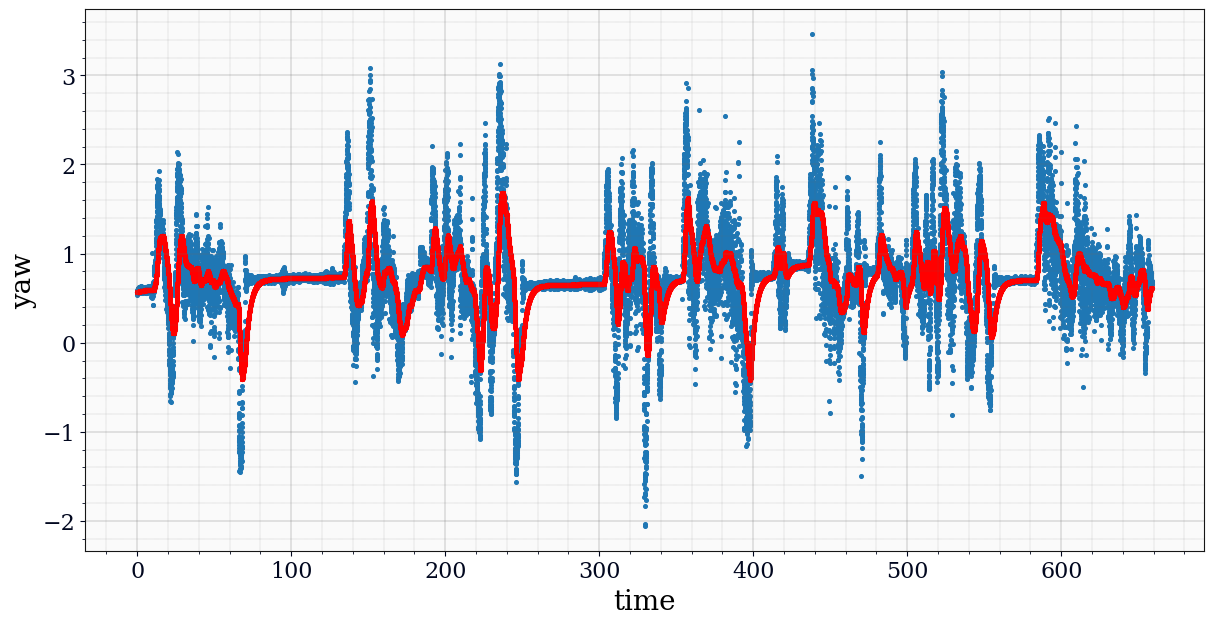

In [32]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=accel_x, s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['new_Accel'], c = 'red', s=7)
plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [33]:
from scipy import integrate
y = accel_values
x = df_imu['time_seconds_plot']

vel_x = integrate.cumtrapz( y, x, initial=x[0])
vel_values = []
for v in vel_x:
    vel_values.append(v)
df_imu['linear_vel_cor_x'] = vel_values
df_imu['linear_vel_cor_x']





0          0.000000
1          0.014135
2          0.028310
3          0.042508
4          0.056905
            ...    
26346    480.940043
26347    480.955503
26348    480.970527
26349    480.985861
26350    481.001356
Name: linear_vel_cor_x, Length: 26351, dtype: float64

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


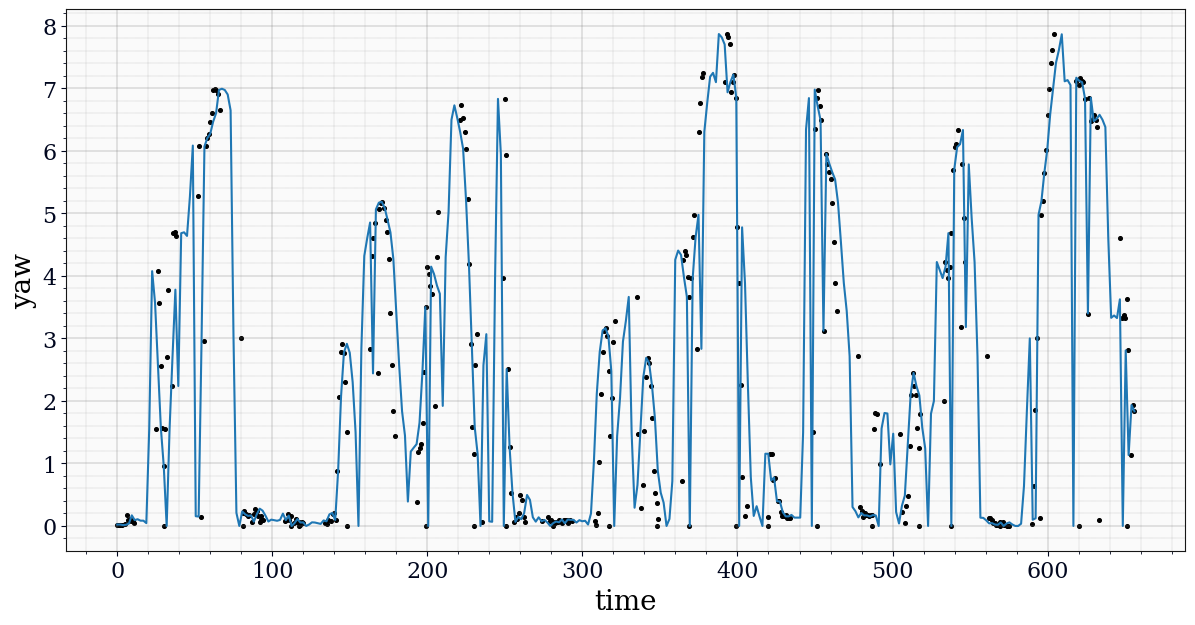

In [34]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_gps['time'], y=df_gps['vel_gps'], c = 'black', s=7)
# ax[0].scatter(x= df_imu['time_seconds_plot'], y= df_imu['linear_vel_cor_x'], s=7)
plt.plot(df_gps['time_Check'], df_gps['vel_gps'])

plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [35]:
#velocity from gps and find constant velocity intervals
vel_gps = df_gps['vel_gps']
time_gps = df_gps['time']
time_values = []
for i, vel in enumerate(vel_gps):
    if vel<0.5:
        time = time_gps[i]
        time_values.append(time)


In [36]:
# time_values
end_values = []
end_values.append(time_values[0])
for i in range(1, len(time_values)):
    if time_values[i] - time_values[i-1] < 3:
        end_values.append(time_values[i])
end_values[0:20]
        


[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 54, 81, 82, 83, 84, 85, 87, 88, 89]

In [37]:
lengt = 0
start_time = []
start = end_values[0]
end_time = []

for i  in range(1, len(end_values)):
        if (end_values[i] - end_values[i-1]) < 3  :
            lengt = lengt + 1
        else:
            
            if lengt > 4:
                start = end_values[i- lengt -1]
                end = end_values[i-1]
                start_time.append(start)
                end_time.append(end)
                lengt = 0
            else:
                lengt = 0
                continue


start_time, end_time


([0, 81, 109, 135, 257, 279, 427, 480, 563],
 [11, 94, 120, 141, 263, 293, 434, 487, 575])

In [38]:
#calculate bias dynamically
bias = []

for i in range(0, len(start_time)-1):
    accel_c = df_imu['new_Accel'][start_time[i]:end_time[i]]
    bias_i = (df_imu['new_Accel'][start_time[i]:end_time[i]]).mean()
#     bias_i = ((df_imu['new_Accel'][start_time[i]] + df_imu['new_Accel'][end_time[i]]) /2)
    bias.append(bias_i)


bias

[0.5668469468893164,
 0.5778280153907117,
 0.579748837546417,
 0.5814753702852599,
 0.5892885281789221,
 0.591607526346392,
 0.5961880180749116,
 0.6863377337969598]

In [39]:
df_imu['new_Accel'][start_time[i]:end_time[i]].mean()

0.6863377337969598

In [80]:
#convert start_time of gps and find index in imu time
start_index_imu_time = []
for i in range(0, len(start_time)-1):
    for j,time in enumerate(df_imu['time_seconds_plot']):
        if time >= start_time[i]:
            start_imu_time_index = j
            start_index_imu_time.append(start_imu_time_index)
            break
start_index_imu_time.append(len(df_imu['time_seconds_plot'])   )     
# start_index_imu_time.append(df_imu['time_seconds_plot'][len(df_imu['time_seconds_plot'])-1])
start_index_imu_time, len(df_imu['time_seconds_plot'])

([0, 3241, 4361, 5401, 10281, 11160, 17081, 19201, 26351], 26351)

In [81]:
#convert start_time of gps and find index in imu time
end_index_imu_time = []
for i in range(0, len(end_time)-1):
    for j,time in enumerate(df_imu['time_seconds_plot']):
        if time > end_time[i]:
            end_imu_time_index = j
            end_index_imu_time.append(end_imu_time_index)
            break
end_index_imu_time.append(len(df_imu['time_seconds_plot'])   )     
# start_index_imu_time.append(df_imu['time_seconds_plot'][len(df_imu['time_seconds_plot'])-1])
end_index_imu_time, len(df_imu['time_seconds_plot'])

([441, 3761, 4801, 5640, 10521, 11721, 17361, 19481, 26351], 26351)

In [99]:
df_imu['bias_Accel']  = 0

In [102]:
start_index_imu_time

[0, 3241, 4361, 5401, 10281, 11160, 17081, 19201, 26351]

In [106]:
bias_corrected_accel = []
# start_j = 0
for i in range(0, len(bias)-1):
    for j in range(start_index_imu_time[i], len(df_imu['new_Accel'])):
            print(j, start_index_imu_time[i+1] ,len(df_imu['new_Accel']))
        
            if j >= start_index_imu_time[i] and j < start_index_imu_time[i+1]:
                df_imu['bias_Accel'][j] = (df_imu['new_Accel'][j] - bias[i])
            
                
            if i == len(bias)-2:
                df_imu['bias_Accel'][j] = (df_imu['new_Accel'][j] - bias[i])
    
            else:
                continue

df_imu['bias_Accel']

0 3241 26351
1 3241 26351
2 3241 26351
3 3241 26351
4 3241 26351
5 3241 26351
6 3241 26351
7 3241 26351
8 3241 26351
9 3241 26351
10 3241 26351
11 3241 26351
12 3241 26351
13 3241 26351
14 3241 26351
15 3241 26351
16 3241 26351
17 3241 26351
18 3241 26351
19 3241 26351
20 3241 26351
21 3241 26351
22 3241 26351
23 3241 26351
24 3241 26351
25 3241 26351
26 3241 26351
27 3241 26351
28 3241 26351
29 3241 26351
30 3241 26351
31 3241 26351
32 3241 26351
33 3241 26351
34 3241 26351
35 3241 26351
36 3241 26351
37 3241 26351
38 3241 26351
39 3241 26351
40 3241 26351
41 3241 26351
42 3241 26351
43 3241 26351
44 3241 26351
45 3241 26351
46 3241 26351
47 3241 26351
48 3241 26351
49 3241 26351
50 3241 26351
51 3241 26351
52 3241 26351
53 3241 26351
54 3241 26351
55 3241 26351
56 3241 26351
57 3241 26351
58 3241 26351
59 3241 26351
60 3241 26351
61 3241 26351
62 3241 26351
63 3241 26351
64 3241 26351
65 3241 26351
66 3241 26351
67 3241 26351
68 3241 26351
69 3241 26351
70 3241 26351
71 3241 26351
72

19475 3241 26351
19476 3241 26351
19477 3241 26351
19478 3241 26351
19479 3241 26351
19480 3241 26351
19481 3241 26351
19482 3241 26351
19483 3241 26351
19484 3241 26351
19485 3241 26351
19486 3241 26351
19487 3241 26351
19488 3241 26351
19489 3241 26351
19490 3241 26351
19491 3241 26351
19492 3241 26351
19493 3241 26351
19494 3241 26351
19495 3241 26351
19496 3241 26351
19497 3241 26351
19498 3241 26351
19499 3241 26351
19500 3241 26351
19501 3241 26351
19502 3241 26351
19503 3241 26351
19504 3241 26351
19505 3241 26351
19506 3241 26351
19507 3241 26351
19508 3241 26351
19509 3241 26351
19510 3241 26351
19511 3241 26351
19512 3241 26351
19513 3241 26351
19514 3241 26351
19515 3241 26351
19516 3241 26351
19517 3241 26351
19518 3241 26351
19519 3241 26351
19520 3241 26351
19521 3241 26351
19522 3241 26351
19523 3241 26351
19524 3241 26351
19525 3241 26351
19526 3241 26351
19527 3241 26351
19528 3241 26351
19529 3241 26351
19530 3241 26351
19531 3241 26351
19532 3241 26351
19533 3241 263

17232 4361 26351
17233 4361 26351
17234 4361 26351
17235 4361 26351
17236 4361 26351
17237 4361 26351
17238 4361 26351
17239 4361 26351
17240 4361 26351
17241 4361 26351
17242 4361 26351
17243 4361 26351
17244 4361 26351
17245 4361 26351
17246 4361 26351
17247 4361 26351
17248 4361 26351
17249 4361 26351
17250 4361 26351
17251 4361 26351
17252 4361 26351
17253 4361 26351
17254 4361 26351
17255 4361 26351
17256 4361 26351
17257 4361 26351
17258 4361 26351
17259 4361 26351
17260 4361 26351
17261 4361 26351
17262 4361 26351
17263 4361 26351
17264 4361 26351
17265 4361 26351
17266 4361 26351
17267 4361 26351
17268 4361 26351
17269 4361 26351
17270 4361 26351
17271 4361 26351
17272 4361 26351
17273 4361 26351
17274 4361 26351
17275 4361 26351
17276 4361 26351
17277 4361 26351
17278 4361 26351
17279 4361 26351
17280 4361 26351
17281 4361 26351
17282 4361 26351
17283 4361 26351
17284 4361 26351
17285 4361 26351
17286 4361 26351
17287 4361 26351
17288 4361 26351
17289 4361 26351
17290 4361 263

18203 5401 26351
18204 5401 26351
18205 5401 26351
18206 5401 26351
18207 5401 26351
18208 5401 26351
18209 5401 26351
18210 5401 26351
18211 5401 26351
18212 5401 26351
18213 5401 26351
18214 5401 26351
18215 5401 26351
18216 5401 26351
18217 5401 26351
18218 5401 26351
18219 5401 26351
18220 5401 26351
18221 5401 26351
18222 5401 26351
18223 5401 26351
18224 5401 26351
18225 5401 26351
18226 5401 26351
18227 5401 26351
18228 5401 26351
18229 5401 26351
18230 5401 26351
18231 5401 26351
18232 5401 26351
18233 5401 26351
18234 5401 26351
18235 5401 26351
18236 5401 26351
18237 5401 26351
18238 5401 26351
18239 5401 26351
18240 5401 26351
18241 5401 26351
18242 5401 26351
18243 5401 26351
18244 5401 26351
18245 5401 26351
18246 5401 26351
18247 5401 26351
18248 5401 26351
18249 5401 26351
18250 5401 26351
18251 5401 26351
18252 5401 26351
18253 5401 26351
18254 5401 26351
18255 5401 26351
18256 5401 26351
18257 5401 26351
18258 5401 26351
18259 5401 26351
18260 5401 26351
18261 5401 263

14642 10281 26351
14643 10281 26351
14644 10281 26351
14645 10281 26351
14646 10281 26351
14647 10281 26351
14648 10281 26351
14649 10281 26351
14650 10281 26351
14651 10281 26351
14652 10281 26351
14653 10281 26351
14654 10281 26351
14655 10281 26351
14656 10281 26351
14657 10281 26351
14658 10281 26351
14659 10281 26351
14660 10281 26351
14661 10281 26351
14662 10281 26351
14663 10281 26351
14664 10281 26351
14665 10281 26351
14666 10281 26351
14667 10281 26351
14668 10281 26351
14669 10281 26351
14670 10281 26351
14671 10281 26351
14672 10281 26351
14673 10281 26351
14674 10281 26351
14675 10281 26351
14676 10281 26351
14677 10281 26351
14678 10281 26351
14679 10281 26351
14680 10281 26351
14681 10281 26351
14682 10281 26351
14683 10281 26351
14684 10281 26351
14685 10281 26351
14686 10281 26351
14687 10281 26351
14688 10281 26351
14689 10281 26351
14690 10281 26351
14691 10281 26351
14692 10281 26351
14693 10281 26351
14694 10281 26351
14695 10281 26351
14696 10281 26351
14697 1028

22012 11160 26351
22013 11160 26351
22014 11160 26351
22015 11160 26351
22016 11160 26351
22017 11160 26351
22018 11160 26351
22019 11160 26351
22020 11160 26351
22021 11160 26351
22022 11160 26351
22023 11160 26351
22024 11160 26351
22025 11160 26351
22026 11160 26351
22027 11160 26351
22028 11160 26351
22029 11160 26351
22030 11160 26351
22031 11160 26351
22032 11160 26351
22033 11160 26351
22034 11160 26351
22035 11160 26351
22036 11160 26351
22037 11160 26351
22038 11160 26351
22039 11160 26351
22040 11160 26351
22041 11160 26351
22042 11160 26351
22043 11160 26351
22044 11160 26351
22045 11160 26351
22046 11160 26351
22047 11160 26351
22048 11160 26351
22049 11160 26351
22050 11160 26351
22051 11160 26351
22052 11160 26351
22053 11160 26351
22054 11160 26351
22055 11160 26351
22056 11160 26351
22057 11160 26351
22058 11160 26351
22059 11160 26351
22060 11160 26351
22061 11160 26351
22062 11160 26351
22063 11160 26351
22064 11160 26351
22065 11160 26351
22066 11160 26351
22067 1116

21715 17081 26351
21716 17081 26351
21717 17081 26351
21718 17081 26351
21719 17081 26351
21720 17081 26351
21721 17081 26351
21722 17081 26351
21723 17081 26351
21724 17081 26351
21725 17081 26351
21726 17081 26351
21727 17081 26351
21728 17081 26351
21729 17081 26351
21730 17081 26351
21731 17081 26351
21732 17081 26351
21733 17081 26351
21734 17081 26351
21735 17081 26351
21736 17081 26351
21737 17081 26351
21738 17081 26351
21739 17081 26351
21740 17081 26351
21741 17081 26351
21742 17081 26351
21743 17081 26351
21744 17081 26351
21745 17081 26351
21746 17081 26351
21747 17081 26351
21748 17081 26351
21749 17081 26351
21750 17081 26351
21751 17081 26351
21752 17081 26351
21753 17081 26351
21754 17081 26351
21755 17081 26351
21756 17081 26351
21757 17081 26351
21758 17081 26351
21759 17081 26351
21760 17081 26351
21761 17081 26351
21762 17081 26351
21763 17081 26351
21764 17081 26351
21765 17081 26351
21766 17081 26351
21767 17081 26351
21768 17081 26351
21769 17081 26351
21770 1708

23187 19201 26351
23188 19201 26351
23189 19201 26351
23190 19201 26351
23191 19201 26351
23192 19201 26351
23193 19201 26351
23194 19201 26351
23195 19201 26351
23196 19201 26351
23197 19201 26351
23198 19201 26351
23199 19201 26351
23200 19201 26351
23201 19201 26351
23202 19201 26351
23203 19201 26351
23204 19201 26351
23205 19201 26351
23206 19201 26351
23207 19201 26351
23208 19201 26351
23209 19201 26351
23210 19201 26351
23211 19201 26351
23212 19201 26351
23213 19201 26351
23214 19201 26351
23215 19201 26351
23216 19201 26351
23217 19201 26351
23218 19201 26351
23219 19201 26351
23220 19201 26351
23221 19201 26351
23222 19201 26351
23223 19201 26351
23224 19201 26351
23225 19201 26351
23226 19201 26351
23227 19201 26351
23228 19201 26351
23229 19201 26351
23230 19201 26351
23231 19201 26351
23232 19201 26351
23233 19201 26351
23234 19201 26351
23235 19201 26351
23236 19201 26351
23237 19201 26351
23238 19201 26351
23239 19201 26351
23240 19201 26351
23241 19201 26351
23242 1920

0        0.000153
1        0.000137
2       -0.000135
3       -0.000237
4       -0.000353
           ...   
26346    0.015074
26347    0.015496
26348    0.016170
26349    0.016496
26350    0.017010
Name: bias_Accel, Length: 26351, dtype: float64

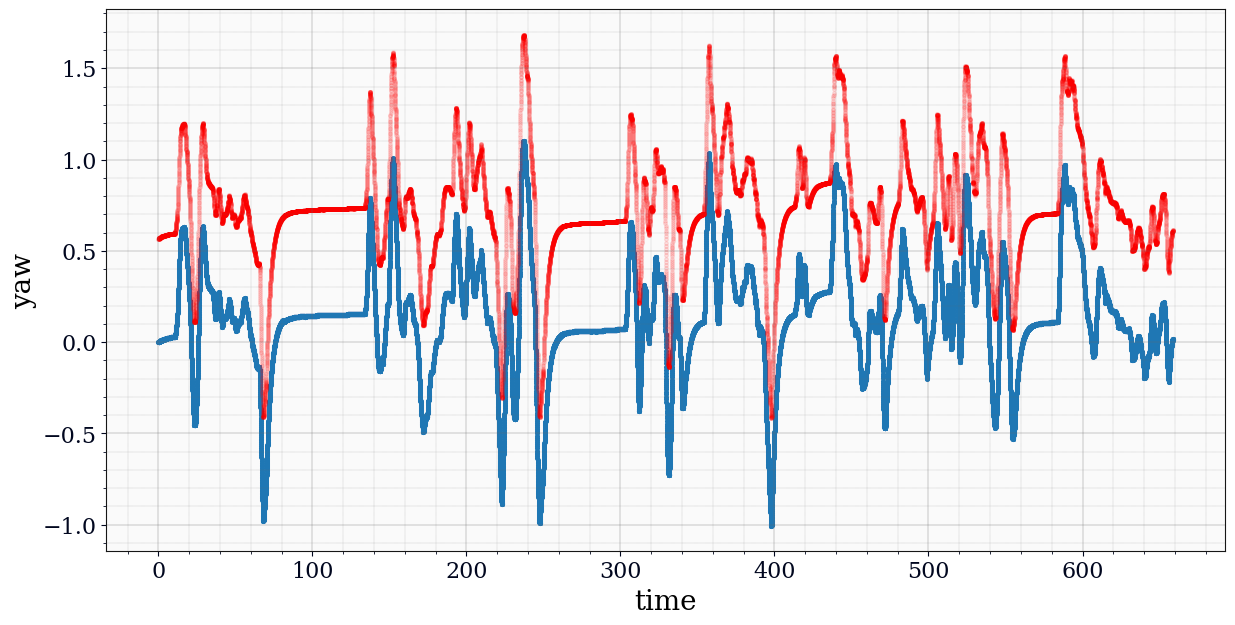

In [108]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
ax[0].scatter(x= df_imu['time_seconds_plot'] ,y=df_imu['bias_Accel'], s=7)
ax[0].scatter(x= df_imu['time_seconds_plot'], y=df_imu['new_Accel'], c = 'red', alpha = 0.1, s=7)
plt.ylabel("yaw")
plt.xlabel("time")
# plt.savefig('/home/marley/northing.png')
plt.show()

In [70]:
x = df_imu['time_seconds_plot'][start_time[i]:start_time[i+1]]
# x[81]

In [111]:
from scipy import integrate
df_imu['bias_Accel'][0] = 0
accel_no_bias = df_imu['bias_Accel']

y = accel_no_bias
x = df_imu['time_seconds_plot']
vel_x = 0
vel_values = []
for i in range(0, len(start_index_imu_time)-1):
    y = accel_no_bias[start_index_imu_time[i]:start_index_imu_time[i+1]]
    x = df_imu['time_seconds_plot'][start_index_imu_time[i]:start_index_imu_time[i+1]]
    vel_x = integrate.cumtrapz( y, x, initial=df_imu['time_seconds_plot'][start_index_imu_time[i]])
    print(len(vel_x))
    for v in vel_x:
        vel_values.append(v)

        
df_imu['linear_vel_x_b'] = vel_values
df_imu['linear_vel_x_b']
# vel_x = integrate.cumtrapz( y, x, initial=x[start_index_imu_time[i]])
len(vel_values)
start_index_imu_time
# len(df_imu['time_seconds_plot'])


3241
1120
1040
4880
879
5921
2120
7150


[0, 3241, 4361, 5401, 10281, 11160, 17081, 19201, 26351]

In [112]:
vel_values

[0.0,
 1.7083833835873193e-06,
 1.736317383031168e-06,
 -2.9158765307503997e-06,
 -1.041115342242655e-05,
 -1.871484592914936e-05,
 -2.4889754758815788e-05,
 -2.873854188125701e-05,
 -2.878331297961138e-05,
 -2.2107405978836056e-05,
 -1.0551244501742411e-05,
 4.491428444382997e-06,
 2.2716200117570997e-05,
 4.4652872633723235e-05,
 7.194993252160586e-05,
 0.0001060119576970812,
 0.00014118448329300382,
 0.00017779084619930972,
 0.0002173308995898036,
 0.0002573313494651479,
 0.0002997977706565816,
 0.00034678203096819596,
 0.0003991022618415321,
 0.0004565670049897396,
 0.000522085997417593,
 0.0005856290820482649,
 0.0006596433016966623,
 0.0007370901465402732,
 0.0008246112436211939,
 0.0009104717459325941,
 0.0010007342812803383,
 0.001094564811782339,
 0.0011892142961820033,
 0.001281777465529498,
 0.0013731254430193358,
 0.0014682777165546668,
 0.0015712073516656153,
 0.001678790264844161,
 0.0017887559402518971,
 0.001902331631050314,
 0.00202102227836208,
 0.002145924039701362,


In [114]:
for i,vel in enumerate(vel_values):
    if vel > 40:
        vel_values[i] = 0
df_imu['linear_vel_x_b'] = vel_values
df_imu['linear_vel_x_b']        

0         0.000000
1         0.000002
2         0.000002
3        -0.000003
4        -0.000010
           ...    
26346    33.992509
26347    33.992896
26348    33.993284
26349    33.993693
26350    33.994117
Name: linear_vel_x_b, Length: 26351, dtype: float64

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


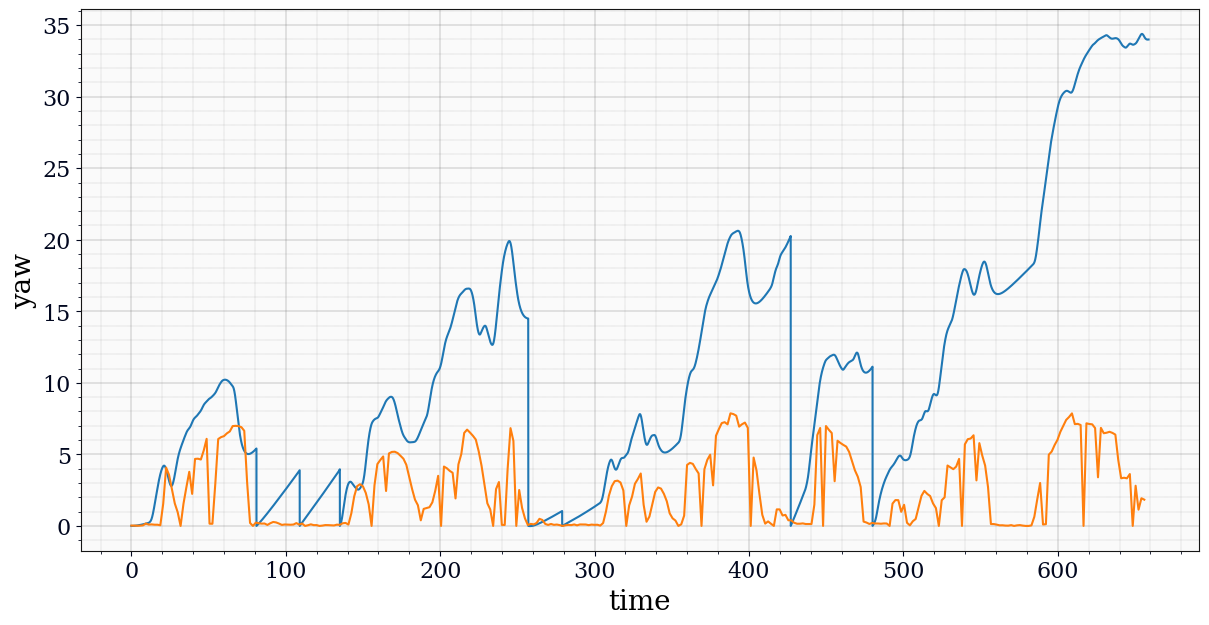

In [115]:
fig, ax = bagpy.create_fig(1)
ax[0].grid(True)
# ax[0].scatter(x= df_imu['time_seconds_plot'], y= df_imu['linear_vel_x_b'], s=7)
plt.plot(df_imu['time_seconds_plot'], df_imu['linear_vel_x_b'])
plt.plot(df_gps['time_Check'], df_gps['vel_gps'])
plt.ylabel("yaw")
plt.xlabel("time")
plt.show()


In [ ]:
#fwd vel vs distance

